In [2]:
import torch
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch import autograd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from torchvision import transforms, datasets
from PIL import Image
import pandas as pd
import re
import torch.nn as nn
from PIL import Image, ImageFont, ImageDraw, ImageEnhance
import datetime, os, copy
from auxiliary import yoloLoss, nms, decoder

In [26]:
classes_lbls = ['Atelectasis', 'Effusion', 'Cardiomegaly', 'Infiltrate', 'Pneumonia', 'Pneumothorax', 'Mass', 'Nodule']

In [5]:
trainX = np.load('trainX.npy')
trainY = np.load('trainY.npy')
testX = np.load('testX.npy')
testY = np.load('testY.npy')

In [6]:
print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)

(890, 3, 448, 448)
(890, 7, 7, 48)
(94,)
(94, 4)


In [7]:
def to_tensor(numpy_array):
    return torch.from_numpy(numpy_array).float()

In [8]:
def to_variable(tensor):
    if torch.cuda.is_available():
        tensor = tensor.cuda()
    return torch.autograd.Variable(tensor)

In [9]:
class Flatten(nn.Module):
    def forward(self, input_val):
        dim = input_val.size()
        return input_val.view(dim[0], dim[1]*dim[2]*dim[3])

In [10]:
class yolo_model(nn.Module):
    def __init__(self):
        super(yolo_model, self).__init__()
        self.network = nn.Sequential(
            # Layer 1 448x448x3 --> 112x112x64
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(negative_slope=0.1),
            nn.MaxPool2d(2, stride=2),
            
            # Layer 2 112x112x64 --> 56x56x192
            nn.Conv2d(in_channels=64, out_channels=192, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(192),
            nn.LeakyReLU(negative_slope=0.1),
            nn.MaxPool2d(2, stride=2),

            # Layer 3 56x56x192 --> 56x56x128
            nn.Conv2d(in_channels=192, out_channels=128, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(negative_slope=0.1),
            
            # Layer 4 56x56x128 --> 56x56x256
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(negative_slope=0.1),

            # Layer 5 56x56x256 --> 56x56x256
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(negative_slope=0.1),
            

            # Layer 6 56x56x256 --> 28x28x512
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(negative_slope=0.1),
            nn.MaxPool2d(2, stride=2),
            
            # Layer 7 28x28x512 --> 28x28x256
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(negative_slope=0.1),

            # Layer 8 28x28x256 --> 28x28x512
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(negative_slope=0.1),
    

            # Layer 9 8x28x512 --> 28x28x256
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(negative_slope=0.1),

            # Layer 10 28x28x256 --> 28x28x512
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(negative_slope=0.1),

            # Layer 11 8x28x512 --> 28x28x256
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(negative_slope=0.1),

            # Layer 12 28x28x256 --> 28x28x512
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(negative_slope=0.1),

            # Layer 13 8x28x512 --> 28x28x256
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(negative_slope=0.1),  

            # Layer 14 28x28x256 --> 28x28x512
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(negative_slope=0.1),

            # Layer 15 28x28x512 --> 28x28x512
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(negative_slope=0.1),

            # Layer 16 28x28x512 --> 14x14x1024
            nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(negative_slope=0.1),
            nn.MaxPool2d(2, stride=2),

            # Layer 17 14x14x1024 --> 14x14x512
            nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(negative_slope=0.1),

            # Layer 18 14x14x512 --> 14x14x1024
            nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(negative_slope=0.1),

            # Layer 19 14x14x1024 --> 14x14x512
            nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(negative_slope=0.1),

            # Layer 20 14x14x512 --> 14x14x1024
            nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(negative_slope=0.1),
            
            # Layer 21 14x14x1024 --> 14x14x1024
            nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(negative_slope=0.1),

            # Layer 22 14x14x1024 --> 7x7x1024
            nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(negative_slope=0.1),

            # Layer 23 7x7x1024 --> 7x7x1024
            nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(negative_slope=0.1),
            
            # Layer 24 7x7x1024 --> 7x7x1024
            nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(negative_slope=0.1))
        
        self.flatten = Flatten() 
            # Layer 25 
        self.linear1 = nn.Linear(in_features=50176, out_features=512)
            
            # Layer 26
        self.linear2 = nn.Linear(in_features=512, out_features=1024)
            
            # Layer 27
        self.linear3 = nn.Linear(in_features=1024, out_features=2352)
            
    def forward(self,x):
        y = self.network(x)
        y = self.flatten(y)
        y = self.linear1(y)
        y = self.linear2(y)
        y = self.linear3(y)
        return y.view(-1,7,7,48)

In [11]:
class LungsDataset (torch.utils.data.TensorDataset):

    def __init__(self, features, labels):
        self.features = features
        if isinstance(labels, np.ndarray):
            self.labels = labels
        else:
            self.labels = None
        
    def __len__(self):
        return self.features.shape[0]

    def __getitem__(self, idx):
        data =  self.features[idx]
        label = self.labels[idx]
        return data,label

In [12]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.xavier_normal(m.weight.data)

## Training

In [255]:
def train_model(X,Y):
    min_loss = 1000
    m = X.shape
    minibatch_size = 16
    num_epochs = 80
    model = yolo_model()
    loss_fn = yoloLoss(7,8,5,0.5)
    optim = torch.optim.Adam(model.parameters(), lr = 0.0001, weight_decay=0.0004)
    if torch.cuda.is_available():
        model = model.cuda()
        loss_fn = loss_fn.cuda()

    print('Train begin')
    model.apply(weights_init)
    model.train()
    
    dataset = LungsDataset(X, Y)
    data_loader = torch.utils.data.DataLoader(dataset, batch_size=minibatch_size, shuffle=True)
    
    for epoch in range(num_epochs):
        losses = []
        i = 1
        for (input_val, labels) in data_loader:
            optim.zero_grad() 
            prediction = model(to_variable(input_val.float()))
            #print('Predictions Completed')
            loss = loss_fn(prediction, to_variable(labels.float())) 
            #print('Loss forward completed')
            loss.backward() 
            #print('Loss backward completed')
            losses.append(loss.data.cpu().numpy())
            
            optim.step()  # Update the network
            #print('Iter {} completed'.format(i))
            #print(loss.data.cpu().numpy())
            i+=1      
        print("Epoch {} Loss: {:.4f}".format(epoch, np.asscalar(np.mean(losses))))
        if np.asscalar(np.mean(losses)) < min_loss:
            torch.save(model.state_dict(), 'yolo.pytorch')
            print('Model Saved')
            min_loss = np.asscalar(np.mean(losses))
    return model,losses

In [256]:
model, losses = train_model(trainX, trainY)

Train begin
Predictions Completed
Loss forward completed
Loss backward completed
Iter 1 completed
[8.726579]
Predictions Completed
Loss forward completed
Loss backward completed
Iter 2 completed
[52.054043]
Predictions Completed
Loss forward completed
Loss backward completed
Iter 3 completed
[19.01066]
Predictions Completed
Loss forward completed
Loss backward completed
Iter 4 completed
[30.113161]
Predictions Completed
Loss forward completed
Loss backward completed
Iter 5 completed
[34.60265]
Predictions Completed
Loss forward completed
Loss backward completed
Iter 6 completed
[16.44546]
Predictions Completed
Loss forward completed
Loss backward completed
Iter 7 completed
[24.691956]
Predictions Completed
Loss forward completed
Loss backward completed
Iter 8 completed
[22.339218]
Predictions Completed
Loss forward completed
Loss backward completed
Iter 9 completed
[13.502955]
Predictions Completed
Loss forward completed
Loss backward completed
Iter 10 completed
[14.605333]
Predictions

Loss forward completed
Loss backward completed
Iter 84 completed
[10.311758]
Predictions Completed
Loss forward completed
Loss backward completed
Iter 85 completed
[14.995461]
Predictions Completed
Loss forward completed
Loss backward completed
Iter 86 completed
[8.555689]
Predictions Completed
Loss forward completed
Loss backward completed
Iter 87 completed
[7.549234]
Predictions Completed
Loss forward completed
Loss backward completed
Iter 88 completed
[9.021425]
Predictions Completed
Loss forward completed
Loss backward completed
Iter 89 completed
[7.482743]
Predictions Completed
Loss forward completed
Loss backward completed
Iter 90 completed
[11.88095]
Predictions Completed
Loss forward completed
Loss backward completed
Iter 91 completed
[7.306444]
Predictions Completed
Loss forward completed
Loss backward completed
Iter 92 completed
[6.216048]
Predictions Completed
Loss forward completed
Loss backward completed
Iter 93 completed
[12.557997]
Predictions Completed
Loss forward comp

Predictions Completed
Loss forward completed
Loss backward completed
Iter 167 completed
[4.6953154]
Predictions Completed
Loss forward completed
Loss backward completed
Iter 168 completed
[5.0045924]
Predictions Completed
Loss forward completed
Loss backward completed
Iter 169 completed
[4.7877803]
Predictions Completed
Loss forward completed
Loss backward completed
Iter 170 completed
[5.232788]
Predictions Completed
Loss forward completed
Loss backward completed
Iter 171 completed
[8.854263]
Predictions Completed
Loss forward completed
Loss backward completed
Iter 172 completed
[5.654914]
Predictions Completed
Loss forward completed
Loss backward completed
Iter 173 completed
[5.968218]
Predictions Completed
Loss forward completed
Loss backward completed
Iter 174 completed
[5.2505846]
Predictions Completed
Loss forward completed
Loss backward completed
Iter 175 completed
[5.04481]
Predictions Completed
Loss forward completed
Loss backward completed
Iter 176 completed
[6.314618]
Predict

In [13]:
df = pd.read_csv('BBox_List_2017.csv')

In [ ]:
#filepath=os.path.abspath(os.path.join(__file__,'../yolo.pytorch')) 
filepath = '/Users/rayhra/Documents/DeepLearning/Project/Detection/yolo4.pytorch'
load_model = torch.load(filepath, map_location=lambda storage, loc: storage)
model = yolo_model()
model.load_state_dict(load_model)
model.eval()

In [16]:
normalize = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

transform1 = transforms.Compose([
                            transforms.ToTensor(),
                            normalize
                            ])

In [57]:
# Implemented over Coursera Deep Learning Specialization
def ioufun(box1, box2):
    if (box1[0]>box2[2] and box1[1]>box2[3]) or (box2[0]>box1[2] and box2[1]>box1[3]):
        return 0
    xi1 = np.maximum(box1[0],box2[0])
    yi1 = np.maximum(box1[1],box2[1])
    xi2 = np.minimum(box1[2],box2[2])
    yi2 = np.minimum(box1[3],box2[3])
    inter_area = (xi2 - xi1) * (yi2 - yi1)
    box1_area = (np.maximum(box1[0],box1[2])-np.minimum(box1[0],box1[2]))*(np.maximum(box1[1],box1[3])-np.minimum(box1[1],box1[3]))
    box2_area = (np.maximum(box2[0],box2[2])-np.minimum(box2[0],box2[2]))*(np.maximum(box2[1],box2[3])-np.minimum(box2[1],box2[3]))
    union_area = box1_area+box2_area-inter_area
    iou = inter_area/ union_area
    if iou<0 or iou>1:
        return 0
    return iou

## Testing and visualization of test sample
#### Note: Test dataset size 96, index range: 0-95

images/00027685_003.png


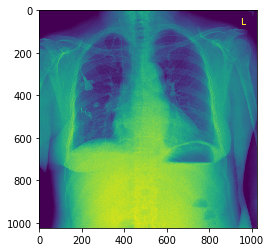

Predicted class: Cardiomegaly
True Class: Cardiomegaly
0.9362657070159912
(137, 104, 289, 216)
(46, 58, 251, 225)
IOU:0.3317139071471253


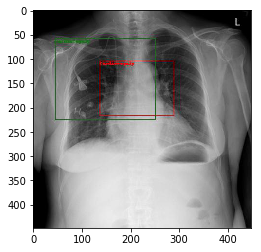

In [56]:
index = 17
file_name = testX[index]
print(file_name)
image = np.array(Image.open(file_name))
plt.imshow(image)
plt.show()
true_labels = testY[index]
out_file = 'prediction.jpeg'
size = (448, 448)
source_img = Image.open(file_name).convert("RGB")
source_img = source_img.resize(size, Image.ANTIALIAS)
img = np.array(source_img)
img = transform1(img)
img = img.numpy()
model.eval()
pred = model(to_variable(to_tensor(img).unsqueeze(0).float()))
boxes,classes,probs =  decoder(pred)
w = size[0]
h = size[1]
row = df.loc[df['Image Index']==file_name[7:]].iloc[0]
true_class = row['Finding Label']
max_prob = -1
for i,box in enumerate(boxes):
    x1 = int(box[0]*w)
    x2 = int(box[2]*w)
    y1 = int(box[1]*h)
    y2 = int(box[3]*h)
    class_ix = classes[i]
    class_ix = int(class_ix) 
    prob = probs[i]
    prob = float(prob)
    class_name = classes_lbls[class_ix]
    if prob>max_prob and class_name==true_class:
        max_prob=prob
        final_class = class_name
        x1p = x1
        y1p = y1
        x2p = x2
        y2p = y2
draw = ImageDraw.Draw(source_img)
draw.rectangle(((x1p,y1p), (x2p,y2p)), outline='red')
draw.text((x1p,y1p), final_class, fill='red')
print('Predicted class: {}'.format(final_class))
x1t = int(true_labels[0]*w)
x2t = int(true_labels[2]*w)
y1t = int(true_labels[1]*h)
y2t = int(true_labels[3]*h)

draw.rectangle(((x1t,y1t), (x2t,y2t)), outline='green')
draw.text((x1t,y1t), true_class, fill='green')
print('True Class: {}'.format(true_class))
source_img.save(out_file, "JPEG")
iou_val = ioufun((x1p,y1p,x2p,y2p),(x1t,y1t,x2t,y2t))
print(prob)
print((x1p,y1p,x2p,y2p))
print((x1t,y1t,x2t,y2t))
image = np.array(Image.open(out_file))
print('IOU:'+ str(iou_val))
#plt.figure(num=None, figsize=(8, 6), dpi=80)
plt.imshow(image)
plt.show()

In [58]:
counter = 0
avg_iou = 0
acc = 0
acc_class=''
for index in range(testX.shape[0]):
    file_name = testX[index]
    true_labels = testY[index]
    size = (448, 448)
    out_file = 'predictions/'+file_name[7:-4]+'.jpeg'
    source_img = Image.open(file_name).convert("RGB")
    source_img = source_img.resize(size, Image.ANTIALIAS)
    img = np.array(source_img)
    img = transform1(img)
    img = img.numpy()
    result = []
    model.eval()
    pred = model(to_variable(to_tensor(img).unsqueeze(0).float())) #1x7x7x48
    pred = pred.cpu()
    boxes,classes,probs =  decoder(pred)
    w = size[0]
    h = size[1]
    max_prob = -1
    final_class = ""
    row = df.loc[df['Image Index']==file_name[7:]].iloc[0]
    true_class = row['Finding Label']
    for i,box in enumerate(boxes):
        x1 = int(box[0]*w)
        x2 = int(box[2]*w)
        y1 = int(box[1]*h)
        y2 = int(box[3]*h)
        class_ix = classes[i]
        class_ix = int(class_ix)
        prob = probs[i]
        prob = float(prob)
        if prob>max_prob:
            acc_class= classes_lbls[class_ix]
        if prob>max_prob and classes_lbls[class_ix]==true_class:
            max_prob=prob
            final_class = classes_lbls[class_ix]
            fx1 = x1
            fy1 = y1
            fx2 = x2
            fy2 = y2

    x1t = int(true_labels[0]*w)
    x2t = int(true_labels[2]*w)
    y1t = int(true_labels[1]*h)
    y2t = int(true_labels[3]*h)

    if final_class:
        iou_val = ioufun((fx1,fy1,fx2,fy2),(x1t,y1t,x2t,y2t))
        if iou_val<1:
            avg_iou+=iou_val
            counter+=1
print("AVERAGE IOU: {}".format(avg_iou/counter))

AVERAGE IOU: 0.11913864914191306
